In [1]:
import os

PROJECT = !gcloud config list --format 'value(core.project)'
PROJECT = PROJECT[0]
BUCKET = PROJECT+"-capstone"
REGION = "us-central1"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

In [25]:
from google.cloud import storage
from collections import defaultdict
import os
import re

# Initialize the storage client
storage_client = storage.Client()

# Set bucket name from environment variable
bucket_name = os.environ["BUCKET"]
bucket = storage_client.bucket(bucket_name)

image_folder = "train"

# List all image files in the specified folder
blobs = bucket.list_blobs(prefix=image_folder)

image_urls = []
labels = []

# Function to extract label from the blob name
def extract_label(blob_name):
    # Example regex to extract label: 'train/category/image.jpg'
    match = re.search(r'train/([^/]+)/.*', blob_name)
    return match.group(1) if match else 'unknown'

# Collect image URLs and their labels
for blob in blobs:
    if blob.name.lower().endswith(('.png', '.jpg', '.jpeg')) and blob.name.lower().startswith('train/tomato'):
        image_urls.append(f"gs://{bucket_name}/{blob.name}")
        labels.append(extract_label(blob.name))

print(f"Found {len(image_urls)} images.")

# Count the number of images for each label
label_counts = defaultdict(int)
for label in labels:
    label_counts[label] += 1

# Print the count of images for each label
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")


Found 18345 images.
Label: Tomato___Bacterial_spot, Number of Images: 1702
Label: Tomato___Early_blight, Number of Images: 1920
Label: Tomato___Late_blight, Number of Images: 1851
Label: Tomato___Leaf_Mold, Number of Images: 1882
Label: Tomato___Septoria_leaf_spot, Number of Images: 1745
Label: Tomato___Spider_mites Two-spotted_spider_mite, Number of Images: 1741
Label: Tomato___Target_Spot, Number of Images: 1827
Label: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Number of Images: 1961
Label: Tomato___Tomato_mosaic_virus, Number of Images: 1790
Label: Tomato___healthy, Number of Images: 1926


In [26]:
# Function to load and preprocess an image
def load_image(image_url):
    image = tf.io.read_file(image_url)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.uint8)  # Convert to uint8 for displaying
    return image

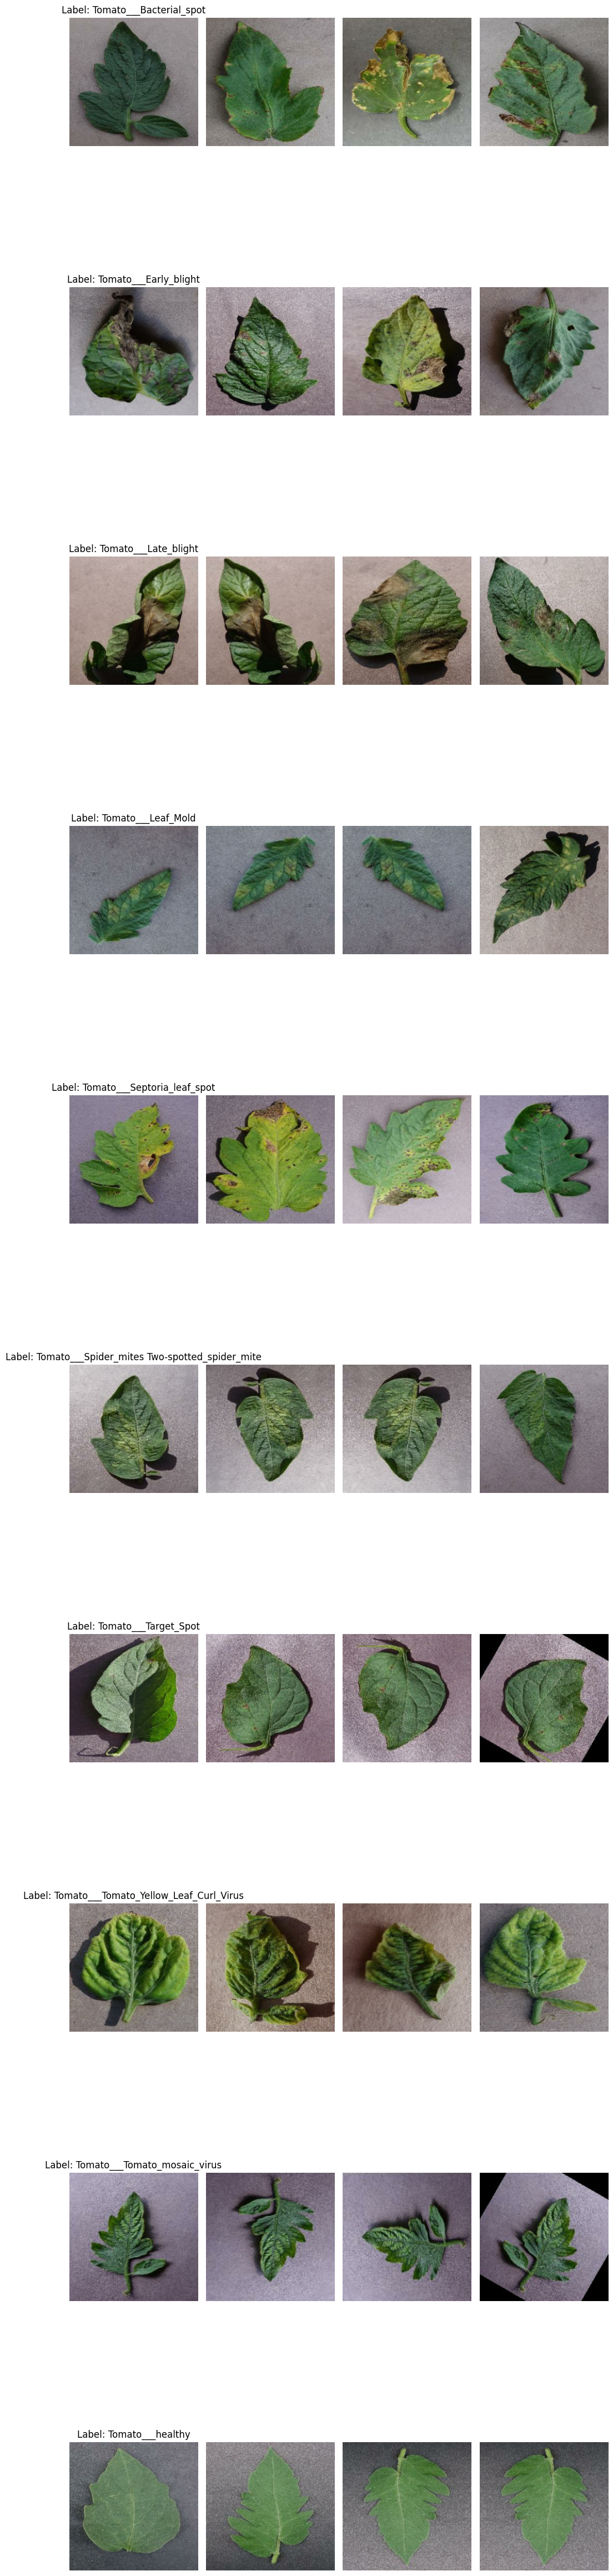

In [27]:
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Group images by labels
label_to_images = defaultdict(list)
for image_url, label in zip(image_urls, labels):
    label_to_images[label].append(image_url)

# representative image for each label
representative_images = {label: urls[:4] for label, urls in label_to_images.items()}

# Plot two representative images for each label
num_labels = len(representative_images)
plt.figure(figsize=(10, num_labels * 5))

for i, (label, image_urls) in enumerate(representative_images.items()):
    for j, image_url in enumerate(image_urls):
        plt.subplot(num_labels, 4, i * 4 + j + 1)
        image = load_image(image_url).numpy()
        plt.imshow(image)
        if j == 0:
            plt.title(f"Label: {label}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
import tensorflow as tf

# Function to load and preprocess images
def normalize_image(image_url):
    image = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224]) 
    image /= 255.0  # Normalize to [0, 1]
    return image

# Create a TensorFlow dataset from the image URLs
image_dataset = tf.data.Dataset.from_tensor_slices(image_urls)
image_dataset = image_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)


2024-06-20 09:14:07.919489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 09:14:14.163484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-20 09:14:14.245623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-

In [18]:
import re

# Function to extract label from image URL
def extract_label(image_url):
    # Example regex to extract label from path: 'gs://bucket_name/category/image.jpg'
    match = re.search(r'gs://.*/(.+?)/.*\.jpg', image_url)
    label = match.group(1) if match else 'unknown'
    return label

# Extract labels from image URLs
labels = [extract_label(url) for url in image_urls]

# Encode labels to integers
label_names = sorted(set(labels))
label_to_index = {name: index for index, name in enumerate(label_names)}
encoded_labels = [label_to_index[label] for label in labels]

# Create a TensorFlow dataset for labels
label_dataset = tf.data.Dataset.from_tensor_slices(encoded_labels)

# Combine image and label datasets
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))


In [19]:
batch_size = 32

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(image_urls))
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# # Define a simple model for demonstration purposes
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(len(label_names), activation='softmax')
# ])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(dataset, epochs=10)
